# Control óptimo para un modelo SIR estocástico multipoblacional

## Francisco Valentín Valerio López
## Facultad de Ciencias Físico Matemáticas - Benemérita Universidad Autónoma de Puebla

### Introducción

Hemos llegado al punto final de esta investigación. Finalmente, extendemos el modelo SIR controlado estocástico para considerar la estructura espacial de la población.

Similar a los sistemas presentados en las notebooks anteriores, presentamos el modelo SIR metapoblacional estocástico con control en la tasa de transmisión para $n$ parches, dado por el siguiente sistema de ecuaciones diferenciales estocásticas:

$$
    \begin{split}
        dS_i &= \left[ - (1- u_i) \beta_i S_i \sum_{j=1}^n m_{ij} I_j \right] dt - \sigma_i \beta_i S_i \sum_{j=1}^n m_{ij} I_j dW_i \\
        dI_i &= \left[ (1-u_i) \beta_i S_i \sum_{j=1}^n m_{ij} I_j - \gamma_i I_i \right] dt + \sigma_i \beta_i S_i \sum_{j=1}^n m_{ij} I_j dW_i \\
        dR_i &= \gamma_i I_i dt \\
    \end{split} \tag{1}
$$

Supongamos que $n=2$, entonces tenemos:

$$
   \begin{split}
        dS_1 &= -(1-u_1) \beta_1 S_1 I_1 \, dt - \sigma_1 S_1 I_1 dW_1 \\
        dI_1 &= ((1-u_1) \beta_1 S_1 - \gamma_1 I_1) \, dt + \sigma_1 S_1 I_1 dW_1 \\
        dR_1 &= \gamma_1 I_1 dt \\
        dS_2 &= -(1-u_2) \beta_2 S_2 I_2 \, dt - \sigma_2 S_2 I_2 dW_2 \\
        dI_2 &= ((1-u_2) \beta_2 S_2 - \gamma_2 I_2) \, dt + \sigma_2 S_2 I_2 dW_2 \\
        dR_2 &= \gamma_2 I_2 dt \\
    \end{split} \tag{2} 
$$

Considerando nuevamente que: 

$$
    g(I,u) = a I^2 + b u^2 \quad a,b \in \mathbb{R} \tag{3}
$$

Al sustituir en la ecuación de Hamilton-Jacobi-Bellman estocástica, y aplicando el principio de optimalidad de Bellman, los controles óptimos para las subpoblaciones 1 y 2 están dados como:

$$
     \boxed{
    u_1^* = - \frac{\beta_1 S_1 (m_{11} I_1 + m_{12} I_2)}{2 b_1} \left( \frac{\partial J}{\partial S_1} - \frac{\partial J}{\partial I_1} \right)
    } \tag{4}
$$

y

$$
     \boxed{
    u_2^* = - \frac{\beta_2 S_2 (m_{21} I_1 + m_{22} I_2)}{2 b_2} \left( \frac{\partial J}{\partial S_2} - \frac{\partial J}{\partial I_2} \right)
    } \tag{5}
$$

Finalmente, la ecuación a resolver es la siguiente:

$$
    \boxed{
    \begin{split}
        &\frac{\partial J}{\partial t} + a_1 I_1^2 + a_2 I_2^2 - \frac{(\beta_1 S_1)^2}{2 b_1} (m_{11} I_1 + m_{12} I_2)^2 \left[ \frac12 \left( \left(\frac{\partial J}{\partial S_1} \right)^2 + \left( \frac{\partial J}{\partial I_1} \right)^2 \right) - \frac{\partial J}{\partial S_1} \frac{\partial J}{\partial I_1} \right] \\
        &- \frac{(\beta_2 S_2)^2}{2 b_2} (m_{21} I_1 + m_{22} I_2)^2 \left[ \frac12 \left( \left( \frac{\partial J}{\partial S_2} \right)^2 + \left( \frac{\partial J}{\partial I_2} \right)^2 \right) - \frac{\partial J}{\partial S_2} \frac{\partial J}{\partial I_2} \right]  + \beta_1 S_1 (m_{11} I_1 + m_{12} I_2) \left( \frac{\partial J}{\partial I_1} - \frac{\partial J}{\partial S_1} \right) \\
        &+ \beta_2 S_2 (m_{21} I_1 + m_{22} I_2) \left( \frac{\partial J}{\partial I_2} - \frac{\partial J}{\partial S_2} \right) - \gamma_1 I_1 \frac{\partial J}{\partial I_1} - \gamma_2 I_2 \frac{\partial J}{\partial I_2} + \frac12 \left[ \sigma_1^2 \left( \frac{\partial^2 J}{\partial S_1^2} + \frac{\partial^2 J}{\partial I_1^2} \right) + \sigma_2^2 \left( \frac{\partial^2 J}{\partial S_2^2} + \frac{\partial^2 J}{\partial I_2^2} \right) \right] = 0
    \end{split}} \tag{6}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Parámetros del entrenamiento y la simulación

epochs = 3000

a = np.array([5.0, 6.0])

b = np.array([1.5, 2.5])

beta = np.array([2.4, 2.9])

gamma = np.array([1.9, 1.7])

m = np.array([[0.6, 0.4],
              [0.2, 0.8]])

sigma = np.array([0.5, 0.4])

points = 5000

In [3]:
class HJB_SIR_Stochastic_Meta(Sequential):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name = 'Loss')
        self.j_tracker = keras.metrics.Mean(name = 'J')

    @property

    def metrics(self):
        return [self.loss_tracker, self.j_tracker]
    
    def train_step(self, data):
        S = tf.random.uniform((points, 2), minval = 0, maxval = 1)
        I = tf.random.uniform((points, 2), minval = 0, maxval = 1)
        t = tf.zeros((points, 1), dtype = tf.float32)

        batch_size = tf.shape(S)[0]

        with tf.GradientTape(persistent = True) as tape:

            tape.watch(S)
            tape.watch(I)
            tape.watch(t)

            J = self(tf.concat([S, I, t * tf.ones((batch_size, 1))], axis = 1))

            [dJ_dS, dJ_dI] = tape.gradient(J, [S, I])

            dJ_dt = tape.gradient(J, t)

            with tf.GradientTape(persistent = True) as tape2:

                tape2.watch(S)
                tape2.watch(I)

                J = self(tf.concat([S, I, t * tf.ones((batch_size, 1))], axis = 1))

                dJ_dS, dJ_dI = tape2.gradient(J, [S, I])

            d2J_dS2 = tape2.gradient(dJ_dS, S)
            d2J_dI2 = tape2.gradient(dJ_dI, I)

            S0 = tf.zeros((batch_size, 2))
            I0 = tf.zeros((batch_size, 2))

            ic = tf.concat([S0, I0], axis = 1)

            hjb = 10 * (dJ_dt + a[0]*I[:,0]**2 + a[1]*I[:,1]**2
                        - (beta[0]*S[:,0]*(m[0,0]*I[:,0]+m[0,1]*I[:,1]))**2 * (1/(2*b[0])) * ((1/2) * (dJ_dS[:,0]**2 + dJ_dI[:,0]**2) - dJ_dS[:,0] * dJ_dI[:,0])
                        - (beta[1]*S[:,1]*(m[1,0]*I[:,0]+m[1,1]*I[:,1]))**2 * (1/(2*b[1])) * ((1/2) * (dJ_dS[:,1]**2 + dJ_dI[:,1]**2) - dJ_dS[:,1] * dJ_dI[:,1])
                        + (beta[0]*S[:,0]*(m[0,0]*I[:,0]+m[0,1]*I[:,1])) * (dJ_dI[:,0] - dJ_dS[:,0]) - gamma[0]*I[:,0]*dJ_dI[:,0]
                        + (beta[1]*S[:,1]*(m[1,0]*I[:,0]+m[1,1]*I[:,1])) * (dJ_dI[:,1] - dJ_dS[:,1]) - gamma[1]*I[:,1]*dJ_dI[:,1]
                        + (1/2)*(sigma[0]**2*(d2J_dS2[:,0] + d2J_dI2[:,0]) + sigma[1]**2*(d2J_dS2[:,1] + d2J_dI2[:,1])))
            
            loss_function = keras.losses.mean_squared_error(0., hjb) + keras.losses.mean_squared_error(0., ic)

        grads = tape.gradient(loss_function, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss_function)
        self.j_tracker.update_state(J)

        return {'Función de pérdida': self.loss_tracker.result(), 'J': self.j_tracker.result()}

In [4]:
modelo = HJB_SIR_Stochastic_Meta()

modelo.add(Dense(40, activation = 'tanh', input_shape = (5,)))
modelo.add(Dense(35, activation = 'tanh'))
modelo.add(Dense(30, activation = 'tanh'))
modelo.add(Dense(25, activation = 'tanh'))
modelo.add(Dense(20, activation = 'tanh'))
modelo.add(Dense(15, activation = 'tanh'))
modelo.add(Dense(10, activation = 'tanh'))
modelo.add(Dense(5, activation = 'tanh'))
modelo.add(Dense(1, activation = 'exponential'))

In [5]:
modelo.summary()

Model: "hjb_sir__stochastic__meta"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 35)                1435      
                                                                 
 dense_2 (Dense)             (None, 30)                1080      
                                                                 
 dense_3 (Dense)             (None, 25)                775       
                                                                 
 dense_4 (Dense)             (None, 20)                520       
                                                                 
 dense_5 (Dense)             (None, 15)                315       
                                                                 
 dense_6 (Dense)             (None, 10)  

In [6]:
modelo.compile(optimizer = RMSprop(learning_rate = 0.0001), metrics = ['Loss'])

In [7]:
X = np.random.randint(0, 500, size = (points, 5))

Y = np.zeros((points, 1))

In [8]:
start_time = time.time()

history = modelo.fit(X, Y, epochs = epochs, batch_size = 250, verbose = 0)

end_time = time.time()

In [9]:
training_time = end_time - start_time

print(f'Tiempo de entrenamiento: {np.round(training_time,2)} s')
print(f'Tiempo de entrenamiento: {np.round(training_time/60,2)} min')


Tiempo de entrenamiento: 3002.46 s
Tiempo de entrenamiento: 50.04 min


#### Resultados del entrenamiento

In [10]:
print('Valor mínimo de la función de pérdida de la red: ', np.min(np.round(history.history['Función de pérdida'], 3)))

Valor mínimo de la función de pérdida de la red:  0.334


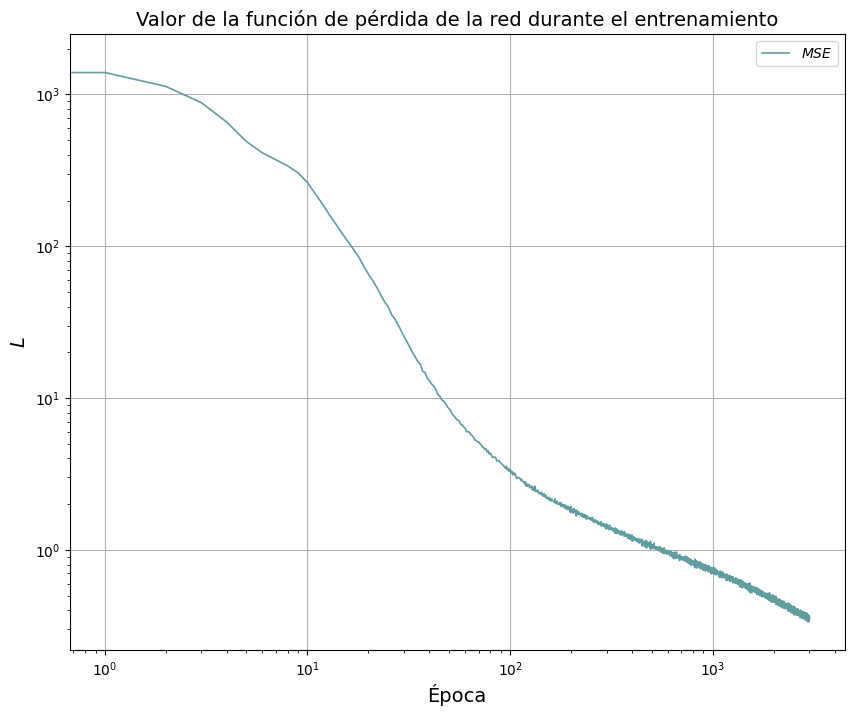

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10,8), dpi = 100)
ax.loglog(history.history['Función de pérdida'], lw = 1.2, color = 'cadetblue', label = r'$MSE$')
ax.set_title('Valor de la función de pérdida de la red durante el entrenamiento', fontsize = 14)
ax.set_xlabel('Época', fontsize = 14)
ax.set_ylabel(r'$L$', fontsize = 14)
ax.legend()
ax.grid()
plt.show()

In [12]:
def u_1(S1, I1, S2, I2, modelo):

    with tf.GradientTape(persistent = True) as tape:

        tape.watch(S1)
        tape.watch(I1)
        tape.watch(S2)
        tape.watch(I2)

        J = modelo(tf.concat([S1, I1, S2, I2, tf.zeros_like(S1)], axis = 1))

        [dJ_dS1, dJ_dI1, dJ_dS2, dJ_dI2] = tape.gradient(J, [S1, I1, S2, I2])

        u1 = tf.math.abs((-beta[0] * S1 * (m[0,0] * I1 + m[0,1] * I2))/(2 * b[0]) * (dJ_dS1 - dJ_dI1))

    return u1


def u_2(S1, I1, S2, I2, modelo):

    with tf.GradientTape(persistent = True) as tape:

        tape.watch(S1)
        tape.watch(I1)
        tape.watch(S2)
        tape.watch(I2)

        J = modelo(tf.concat([S1, I1, S2, I2, tf.zeros_like(S1)], axis = 1))

        [dJ_dS1, dJ_dI1, dJ_dS2, dJ_dI2] = tape.gradient(J, [S1, I1, S2, I2])

        u2 = tf.math.abs((-beta[1] * S2 * (m[1,0] * I1 + m[1,1] * I2))/(2 * b[1]) * (dJ_dS2 - dJ_dI2))

    return u2


In [13]:
# a = np.array([5.9, 6.7])

# b = np.array([5.5, 6.5])

# beta = np.array([2.4, 2.9])

# gamma = np.array([1.9, 1.7])

# m = np.array([[0.5, 0.5],
#              [0.5, 0.5]])

# sigma = np.array([0.3, 0.2])

#### Simulación control

In [14]:
# Subpoblaciones

N_pob = np.array([500, 500])

# Condiciones iniciales

S0 = np.array([499, 499])/N_pob
I0 = (N_pob - S0)/N_pob
R0 = np.array([0.0, 0.0])

dt = 0.000001

t_max = 10

sqrt_dt = np.sqrt(dt)

l = int(t_max/dt) + 1

S = np.zeros((l, 2))
I = np.zeros((l, 2))
R = np.zeros((l, 2))
u = np.zeros((l, 2))


S[0, :] = S0 * N_pob
I[0, :] = I0 * N_pob
R[0, :] = R0 * N_pob

# dW = np.random.randn()

sim_start = time.time()

for i in range(1, l):

    u[i, 0] = u_1(tf.constant([[S[i-1, 0]]], dtype = tf.float32),
                  tf.constant([[I[i-1, 0]]], dtype = tf.float32),
                  tf.constant([[S[i-1, 1]]], dtype = tf.float32),
                  tf.constant([[I[i-1, 1]]], dtype = tf.float32), modelo)
    
    u[i, 1] = u_2(tf.constant([[S[i-1, 0]]], dtype = tf.float32),
                  tf.constant([[I[i-1, 0]]], dtype = tf.float32),
                  tf.constant([[S[i-1, 1]]], dtype = tf.float32),
                  tf.constant([[I[i-1, 1]]], dtype = tf.float32), modelo)
    
    for j in range(2):

        dW = np.random.randn()

        dS = -(1-u[i,j]) * beta[j] * S[i-1, j] * ((m[j,0]*I[i-1,0] + m[j,1]*I[i-1,1])/N_pob[j]) 
        dI = (1-u[i,j]) * beta[j] * S[i-1, j] * ((m[j,0]*I[i-1,0] + m[j,1]*I[i-1,1])/N_pob[j]) - gamma[j] * I[i-1, j]
        dR = gamma[j] * I[i-1, j]

        S[i,j] = S[i-1,j] + dS * dt - sigma[j] * (S[i-1,j]*I[i-1,j])/N_pob[j] * sqrt_dt * dW
        I[i,j] = I[i-1,j] + dS * dt + sigma[j] * (S[i-1,j]*I[i-1,j])/N_pob[j] * sqrt_dt * dW
        R[i,j] = R[i-1,j] + dS * dt

    if i % 1000 == 0:
        print(f"Paso {i}: S = {S[i,:]}, I = {I[i,:]}, R = {R[i,:]}")

sim_end = time.time()

Paso 1000: S = [486.48392591 494.35106673], I = [509.14645148 500.76350062], R = [-1.1858113  -1.44371632]
Paso 2000: S = [471.7976404  492.74773149], I = [521.48717206 499.48816994], R = [-2.35859377 -2.88304929]
Paso 3000: S = [470.31926515 490.85519811], I = [520.66010177 498.50324568], R = [-3.51131654 -4.3217781 ]
Paso 4000: S = [466.14706094 485.724933  ], I = [522.52465887 500.7794123 ], R = [-4.6651401  -5.74882735]
Paso 5000: S = [455.17963846 485.50718523], I = [531.21483855 498.16387651], R = [-5.80376149 -7.16546913]
Paso 6000: S = [886.31241651 839.12120048], I = [989.40321627 854.60629548], R = [438.85681639 347.86274798]
Paso 7000: S = [nan nan], I = [nan nan], R = [nan nan]
Paso 8000: S = [nan nan], I = [nan nan], R = [nan nan]
Paso 9000: S = [nan nan], I = [nan nan], R = [nan nan]
Paso 10000: S = [nan nan], I = [nan nan], R = [nan nan]
Paso 11000: S = [nan nan], I = [nan nan], R = [nan nan]
Paso 12000: S = [nan nan], I = [nan nan], R = [nan nan]
Paso 13000: S = [nan na

KeyboardInterrupt: 

revisar: clip_value en la red
